In [34]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [4]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## Settings

In [35]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 5 # TODO: to be tuned!

In [36]:
data_folder = Path("./data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [35]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

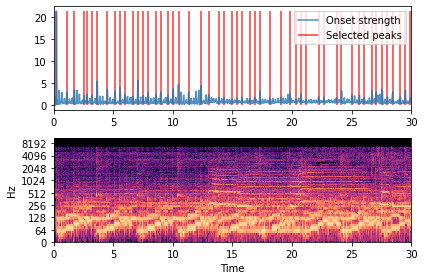

In [12]:
for idx, audio in enumerate(tracks):
    if idx >= 1:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        
        

## Minhash

In [7]:
# TODO

In [37]:
from bitstring import BitArray
import pandas as pd

In [38]:
def timeOfPeaks(peaks, times):
    timesPeaks = []
    
    for i in peaks:
        timesPeaks.append(times[i])
    
    return timesPeaks   

In [39]:
timess = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)

timesPeaks = timeOfPeaks(peaks, timess)

In [40]:
len(peaks) == len(timesPeaks)

True

In [41]:
freqsP = [onset_env[i] for i in peaks]

In [42]:
def fibonacci_hash_float(value):
    
    value = BitArray(float=value, length=64)
    phi = (1 + 5 ** 0.5) / 2
    g = int(2 ** 64 /phi)
    

    value ^= value >> 61
    value = int(g * value.float)
 
    return value

In [43]:
def minhash(freqs, times, threshold = None, duration = None):
    old_threshold = threshold
    f = 0
    out = []
    
    for i in range(0,duration//threshold):

        for fr, tm in zip(freqs,times):
            
            if(tm < threshold and tm > (threshold-old_threshold)):
            
                f += (fibonacci_hash_float(fr) + fibonacci_hash_float(tm))
                
            
        out.append(fibonacci_hash_float(f))    
        
        threshold += old_threshold
    
    out = np.min(out)
    
    return out    

In [44]:
minhash(freqsP, timesPeaks, THRESHOLD, DURATION)

15177341331659686207227635091531936825344

In [45]:
hashtable = []
names = []
data = pd.DataFrame()
for idx, audio in tqdm(enumerate(tracks), total = N_TRACKS):
    names.append(audio)
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    timess = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)

    timesPeaks = timeOfPeaks(peaks, timess)
    freqsP = [onset_env[i] for i in peaks]
    
    
    hashtable.append(minhash(freqsP, timesPeaks, THRESHOLD, DURATION))
    
data['hashid'] = hashtable
data['name'] = names

  0%|          | 0/1413 [00:00<?, ?it/s]

In [46]:
data

,hashid,name
0,8809314921761430321831903154180427087872,data/mp3s-32k/radiohead/Amnesiac/10-Like_Spinn...
1,5119511528279980337641122575311328772096,data/mp3s-32k/radiohead/Amnesiac/04-You_and_Wh...
2,4770671615819546757858838378734241710080,data/mp3s-32k/radiohead/Amnesiac/09-Hunting_Be...
3,8338232921638686128695101109806731100160,data/mp3s-32k/radiohead/Amnesiac/08-Dollars_an...
4,19324035784262834512733025803195077623808,data/mp3s-32k/radiohead/Amnesiac/03-Pilk_Pull_...
...,...,...
1408,7478159304139670705572154198725729714176,data/mp3s-32k/green_day/Warning/06-Misery.wav
1409,15188036870289947370964641704638108663808,data/mp3s-32k/green_day/Warning/09-Jackass.wav
1410,11854228875047508207118086826264295899136,data/mp3s-32k/green_day/Warning/10-Waiting.wav
1411,7319656004305430528007131173444112089088,data/mp3s-32k/green_day/Warning/07-Deadbeat_Ho...


In [56]:
data.to_csv('data/hashtable.csv', index=False)

In [47]:
audio = 'data/queries/track1.wav'

In [49]:
track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
timess = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)
timesPeaks = timeOfPeaks(peaks, timess)
freqsP = [onset_env[i] for i in peaks]
    
h = minhash(freqsP, timesPeaks, THRESHOLD, DURATION)

In [50]:
h

11378598217610016087295790696969422241792

In [51]:
data[data.hashid == h]

,hashid,name
643,11378598217610016087295790696969422241792,data/mp3s-32k/aerosmith/Aerosmith/03-Dream_On.wav
